In [1]:
#Observations
#Capomullin and Ramicane have proven to be the most effective in getting lower final tumor volumes
#Capomulin and Ramicane are also the most consistent treatments when considering variance
#Due to high variance, both Ketapril and Naftisol should be discontinued as trial Drug Regimens

# Dependencies and Setup
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
from scipy.stats import linregress
from scipy import stats

# Study data files
mouse_metadata_path = "data/Mouse_metadata.csv"
study_results_path = "data/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata = pd.read_csv(mouse_metadata_path)
study_results = pd.read_csv(study_results_path)

# Combine the data into a single dataset
mice = pd.merge(mouse_metadata, study_results, on = "Mouse ID", how = "outer")

In [2]:
# Checking the number of mice in the DataFrame.
mice['Mouse ID'].nunique()

249

In [3]:
# Extract duplicate mice by ID number that shows up for Mouse ID and Timepoint.
mice = mice.sort_values(["Mouse ID", "Timepoint"])

In [4]:
# Get all the data for the duplicate mouse ID. 
micedupe = mice[mice.duplicated(['Mouse ID', 'Timepoint'])]
micedupe

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
909,g989,Propriva,Female,21,26,0,45.000000,0
911,g989,Propriva,Female,21,26,5,47.570392,0
913,g989,Propriva,Female,21,26,10,49.880528,0
915,g989,Propriva,Female,21,26,15,53.442020,0
917,g989,Propriva,Female,21,26,20,54.657650,1


In [5]:
# Create a clean DataFrame by dropping the duplicate mouse by its ID.
mice = mice.loc[mice['Mouse ID'] != 'g989']

In [6]:
# Checking the number of mice in the clean DataFrame.
mice['Mouse ID'].nunique()

248

## Summary Statistics

In [7]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen

micegroup = mice.groupby(['Drug Regimen'])['Tumor Volume (mm3)']
#
micemean = micegroup.mean()
micemed = micegroup.median()
micevar = micegroup.var()
micestd = micegroup.std()
micesem = micegroup.sem()
#
summary = {'Mean' : micemean, 'Median' : micemed, 'Variance' : micevar, 'Std. Dev' : micestd, 'Std. Error' : micesem}
#
summary = pd.DataFrame(summary)
summary['Mean'] = summary['Mean'].map("{:.2f}".format)
summary['Median'] = summary['Median'].map("{:.2f}".format)
summary['Variance'] = summary['Variance'].map("{:.2f}".format)
summary['Std. Dev'] = summary['Std. Dev'].map("{:.2f}".format)
summary['Std. Error'] = summary['Std. Error'].map("{:.3f}".format)
summary = pd.DataFrame(summary)
summary

,Mean,Median,Variance,Std. Dev,Std. Error
Drug Regimen,,,,,
Capomulin,40.68,41.56,24.95,4.99,0.329
Ceftamin,52.59,51.78,39.29,6.27,0.470
Infubinol,52.88,51.82,43.13,6.57,0.492
Ketapril,55.24,53.70,68.55,8.28,0.604
Naftisol,54.33,52.51,66.17,8.13,0.596
Placebo,54.03,52.29,61.17,7.82,0.581
Propriva,52.32,50.45,43.85,6.62,0.544
Ramicane,40.22,40.67,23.49,4.85,0.321
Stelasyn,54.23,52.43,59.45,7.71,0.573


## Bar Plots

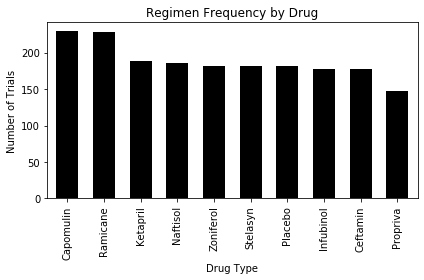

In [8]:
# Generate a bar plot showing number of data points for each treatment regimen using pandas
drugfreq = mice['Drug Regimen'].value_counts()
drugfreq.sort_values(ascending = False)
drugfreq.plot(kind = 'bar', color = 'black', width = 0.6)
#
plt.title("Regimen Frequency by Drug")
plt.ylabel("Number of Trials")
plt.xlabel("Drug Type")
plt.tight_layout()

Text(0, 0.5, 'Number of Trials')

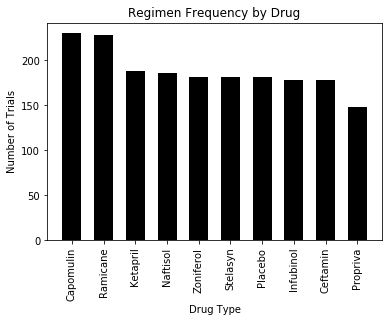

In [24]:
# Generate a bar plot showing number of data points for each treatment regimen using pyplot

drugname = drugfreq.keys()
drugamount = [drugfreq[0], drugfreq[1], drugfreq[2], drugfreq[3], drugfreq[4], 
             drugfreq[5], drugfreq[6], drugfreq[7], drugfreq[8], drugfreq[9]]
ticks = [x for x in drugname]
#
plt.bar(drugname, drugamount, color = "black", width = 0.6)
plt.xticks(ticks, rotation = 'vertical')
plt.title("Regimen Frequency by Drug")
plt.xlabel("Drug Type")
plt.ylabel("Number of Trials")

## Pie Plots

Text(0.5, 1.0, 'Mouse Distribution by Sex')

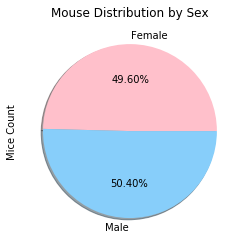

In [23]:
# Generate a pie plot showing the distribution of female versus male mice using pandas
fem = mice.loc[mice['Sex'] == 'Female'].nunique()['Mouse ID']
male = mice.loc[mice['Sex']== 'Male'].nunique()['Mouse ID']
#
gender_dist = pd.DataFrame({'Sex': ['Female', 'Male'], "Mice Count" : [fem, male]})
gender_dist = gender_dist.set_index('Sex')
colors = ['pink', 'lightskyblue']
gender_dist.plot(kind = 'pie', colors = colors, autopct = "%1.2f%%", y = gender_dist.keys(), shadow = True, legend = None)
plt.title("Mouse Distribution by Sex")

Text(0.5, 1.0, 'Mouse Distribution by Sex')

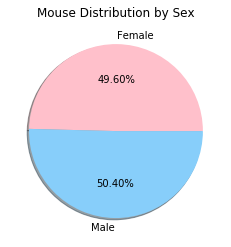

In [11]:
# Generate a pie plot showing the distribution of female versus male mice using pyplot
genders = gender_dist.index
plt.pie(gender_dist['Mice Count'], labels = genders, colors = colors, autopct = "%1.2f%%", shadow = True)
plt.title("Mouse Distribution by Sex")

## Quartiles, Outliers and Boxplots

In [12]:
# Calculate the final tumor volume of each mouse across four of the most promising treatment regimens. Calculate the IQR and quantitatively determine if there are any potential outliers. 

lastdf = mice.groupby("Mouse ID").nth(-1)
lastdf.reset_index()
#
inf = lastdf.loc[lastdf['Drug Regimen']== 'Infubinol']['Tumor Volume (mm3)']
i_qrt= inf.quantile([.25, .5, .75])
i_low = i_qrt[.25]
i_up = i_qrt[.75]
i_med = i_qrt[.5]
i_iqr = i_up - i_low
i_lowb = i_low - (1.5 * i_iqr)
i_upb = i_up + (1.5 * i_iqr)
outlier_inf = inf.loc[(inf < i_lowb) | (inf > i_upb)]
#
cap = lastdf.loc[lastdf['Drug Regimen']== 'Capomulin']['Tumor Volume (mm3)']
cap_qrt = cap.quantile([.25, .5, .75])
cap_low = cap_qrt[.25]
cap_up = cap_qrt[.75]
cap_med = cap_qrt[.5]
cap_iqr = cap_up - cap_low
cap_lowb = cap_low - (1.5 * cap_iqr)
cap_upb = cap_up + (1.5 * cap_iqr)
outlier_cap = cap.loc[(cap < cap_lowb) | (cap > i_upb)]
#
ram = lastdf.loc[lastdf['Drug Regimen']== 'Ramicane']['Tumor Volume (mm3)']
r_qrt = ram.quantile([.25, .5, .75])
r_low = r_qrt[.25]
r_up = r_qrt[.75]
r_med = r_qrt[.5]
r_iqr = r_up - r_low
r_lowb = r_low - (1.5 * r_iqr)
r_upb = r_up + (1.5 * r_iqr)
outlier_r = ram.loc[(ram < r_lowb) | (ram > r_upb)]
#
ceft= lastdf.loc[lastdf['Drug Regimen']== 'Ceftamin']['Tumor Volume (mm3)']
ce_qrt = ceft.quantile([.25, .5, .75])
ce_low = ce_qrt[.25]
ce_up = ce_qrt[.75]
ce_med = ce_qrt[.5]
ce_iqr = ce_up - ce_low
ce_lowb = ce_low - (1.5 * ce_iqr)
ce_upb = ce_up + (1.5 * ce_iqr)
outlier_ce = ceft.loc[(ceft < ce_lowb) | (ceft > ce_upb)]
#

#############################

print("Infubinol---------------------------------------")
print(f"The lower quartile is: {round(i_low,2)}")
print(f"The upper quartile is: {round(i_up,2)}")
print(f"The interquartile range is: {round(i_iqr,2)}")
print(f"The the median is: {round(i_med, 2)} ")
print(f"Values below {round(i_lowb,2)} could be outliers.")
print(f"Values above {round(i_upb,2)} could be outliers.")
if outlier_inf.empty:
    print("There are no outliers")
else:
    print(f"The outliers are: {round(outlier_inf,2)}")
print("------------------------------------------------")
#

print("Capomulin---------------------------------------")
print(f"The lower quartile is: {round(cap_low,2)}")
print(f"The upper quartile is: {round(cap_up,2)}")
print(f"The interquartile range is: {round(cap_iqr,2)}")
print(f"The the median is: {round(cap_med,2)} ")
print(f"Values below {round(cap_lowb,2)} could be outliers.")
print(f"Values above {round(cap_upb,2)} could be outliers.")
if outlier_cap.empty:
    print("There are no outliers")
else:
    print(f"The outliers are: {round(outlier_cap,2)}")
print("------------------------------------------------")
#

print("Ramicane---------------------------------------")
print(f"The lower quartile is: {round(r_low,2)}")
print(f"The upper quartile is: {round(r_up,2)}")
print(f"The interquartile range is: {round(r_iqr,2)}")
print(f"The the median is: {round(r_med,2)}")
print(f"Values below {round(r_lowb,2)} could be outliers.")
print(f"Values above {round(r_upb,2)} could be outliers.")
if outlier_r.empty:
    print("There are no outliers")
else:
    print(f"The outliers are: {round(outlier_r,2)}")
print("------------------------------------------------")
#

print("Ceftamin---------------------------------------")
print(f"The lower quartile  is: {round(ce_low,2)}")
print(f"The upper quartile is: {round(ce_up,2)}")
print(f"The interquartile range is: {round(ce_iqr,2)}")
print(f"The the median is: {round(ce_med,2)} ")
print(f"Values below {round(ce_lowb,2)} could be outliers.")
print(f"Values above {round(ce_upb,2)} could be outliers.")
if outlier_ce.empty:
    print("There are no outliers")
else:
    print(f"The outliers are: {round(outlier_ce,2)}")
print("------------------------------------------------")

Infubinol---------------------------------------
The lower quartile is: 54.05
The upper quartile is: 65.53
The interquartile range is: 11.48
The the median is: 60.17 
Values below 36.83 could be outliers.
Values above 82.74 could be outliers.
The outliers are: Mouse ID
c326    36.32
Name: Tumor Volume (mm3), dtype: float64
------------------------------------------------
Capomulin---------------------------------------
The lower quartile is: 32.38
The upper quartile is: 40.16
The interquartile range is: 7.78
The the median is: 38.13 
Values below 20.7 could be outliers.
Values above 51.83 could be outliers.
There are no outliers
------------------------------------------------
Ramicane---------------------------------------
The lower quartile is: 31.56
The upper quartile is: 40.66
The interquartile range is: 9.1
The the median is: 36.56
Values below 17.91 could be outliers.
Values above 54.31 could be outliers.
There are no outliers
------------------------------------------------
Ceft

Text(0.5, 1.0, 'Final Tumor Volume for 4 Treatments')

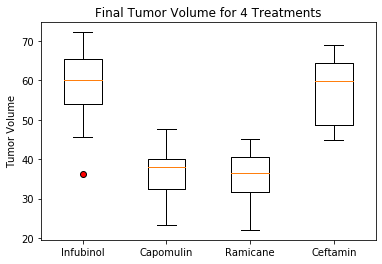

In [39]:
#Boxplot
plt.boxplot([inf, cap, ram, ceft], labels = ['Infubinol', 'Capomulin', 'Ramicane', 'Ceftamin'], flierprops = {"markerfacecolor": "red"})
plt.ylabel("Tumor Volume")
plt.title("Final Tumor Volume for 4 Treatments")

## Line and Scatter Plots

In [40]:
# Generate a line plot of time point versus tumor volume for a mouse treated with a specific Drug
drug = input("Which Drug are you studying? ")
drug_table = mice.loc[mice['Drug Regimen'] == drug]
print(f'Here are the MouseIDs for {drug}:')
drug_table['Mouse ID'].unique()

Which Drug are you studying?  Ramicane


Here are the MouseIDs for Ramicane:


array(['a411', 'a444', 'a520', 'a644', 'c458', 'c758', 'd251', 'e662',
       'g791', 'i177', 'i334', 'j913', 'j989', 'k403', 'm546', 'n364',
       'q597', 'q610', 'r811', 'r921', 's508', 'u196', 'w678', 'y449',
       'z578'], dtype=object)

Which  Mouse ID are you researching? a444


,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
421,a444,Ramicane,Female,10,25,0,45.000000,0
422,a444,Ramicane,Female,10,25,5,44.005975,0
423,a444,Ramicane,Female,10,25,10,44.512560,0
424,a444,Ramicane,Female,10,25,15,43.001280,0
425,a444,Ramicane,Female,10,25,20,41.714619,0
426,a444,Ramicane,Female,10,25,25,42.291394,0
427,a444,Ramicane,Female,10,25,30,42.786278,0
428,a444,Ramicane,Female,10,25,35,41.735951,0
429,a444,Ramicane,Female,10,25,40,42.504926,0
430,a444,Ramicane,Female,10,25,45,43.047543,0


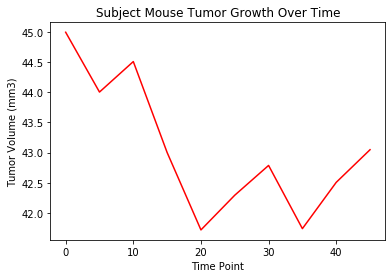

In [41]:
mice_id = input("Which  Mouse ID are you researching?")
indmouse = drug_table.loc[drug_table['Mouse ID'] == mice_id]
plt.plot(indmouse['Timepoint'], indmouse['Tumor Volume (mm3)'], color = 'Red', label = "Tumor Volume over Time")
plt.xlabel('Time Point')
plt.ylabel('Tumor Volume (mm3)')
plt.title('Subject Mouse Tumor Growth Over Time')
indmouse

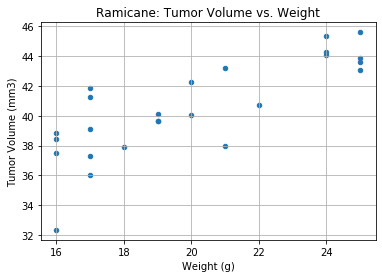

In [42]:
# Generate a scatter plot of mouse weight versus average tumor volume for the Capomulin regimen
scatmice = drug_table.groupby(['Mouse ID']).mean()[['Weight (g)', 'Tumor Volume (mm3)']]
scatmice.plot(kind = 'scatter', x = 'Weight (g)', y = 'Tumor Volume (mm3)', grid = True, title = f"{drug}: Tumor Volume vs. Weight")

## Correlation and Regression

The correlation between weight and average tumor volume is 0.81
Linear Regression is y = 0.77x + 25.16


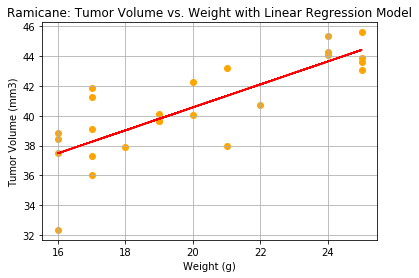

In [43]:
# Calculate the correlation coefficient and linear regression model 
# for mouse weight and avaerage tumor volume for the Capomulin regimen
x = scatmice['Weight (g)']
y = scatmice['Tumor Volume (mm3)']
(slope, intercept, pvalue, rvalue, stderr) = stats.linregress(x,y)
line = slope * x + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
#
plt.scatter(x,y, facecolors= 'orange')
plt.plot(x,line, color = 'red')
plt.grid(b=True)
plt.xlabel("Weight (g)")
plt.ylabel('Tumor Volume (mm3)')
plt.title(f'{drug}: Tumor Volume vs. Weight with Linear Regression Model')
#
cor = st.pearsonr(scatmice['Weight (g)'], scatmice['Tumor Volume (mm3)'])
#
print(f'The correlation between weight and average tumor volume is {round(cor[0],2)}')
print(f'Linear Regression is {line_eq}')